# Graph Neural Network for Multi-Asset Market Modeling — Variant C 📈

This notebook implements a GNN + LSTM model for predicting the next-step direction of Asset A using multi-asset time series, incorporating **learnable attention** over a set of precomputed correlation windows.

### Features
- Candidate correlation windows: **30min, 1h, 2h, 4h**
- **NaN-safe** normalization and correlation calculation.
- **Multi-window attention** (softmax-weighted combination) for dynamic correlation weighting.
- Monitoring attention weights per epoch for **interpretability**.
- Synthetic dataset $T \approx 3000$.

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path


def load_asset(asset):
    freq = '5min'
    DATA_DIR = Path('../dataset')
    path = DATA_DIR / f"{asset}_{freq}.csv"

    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df["system_time"])
    df['timestamp'] = df['timestamp'].dt.round('min')
    df = df.sort_values('timestamp').set_index('timestamp')
    return df[['midpoint','bids_notional_0']]  
    
df_ADA = load_asset("ADA").rename(columns={'midpoint': 'ADA', 'bids_notional_0': 'vol_ADA'})
df_BTC = load_asset("BTC").rename(columns={'midpoint': 'BTC', 'bids_notional_0': 'vol_BTC'})
df_ETH = load_asset("ETH").rename(columns={'midpoint': 'ETH', 'bids_notional_0': 'vol_ETH'})
df = df_ADA.join(df_BTC).join(df_ETH)

df.rename(columns={'ADA': 'price_A', 'vol_ADA': 'vol_A', 'BTC': 'price_B', 'vol_BTC': 'vol_B', 'ETH': 'price_C', 'vol_ETH': 'vol_C'}, inplace=True)
df.reset_index(inplace=True)

T = len(df)

# log returns for later correlation calculation
df['lr_A'] = np.log(df['price_A']).diff().fillna(0)
df['lr_B'] = np.log(df['price_B']).diff().fillna(0)
df['lr_C'] = np.log(df['price_C']).diff().fillna(0)

# direction label for A (target): up (1) if next price > current (0 otherwise)
df['dir_A_next'] = (df['price_A'].shift(-1) > df['price_A']).astype(int)

# 1) Replace zero or negative volumes with a tiny positive constant
for col in ["vol_A", "vol_B", "vol_C"]:
    df[col] = df[col].clip(lower=1e-6)

# 2) Smooth extreme outliers using winsorization (99.5%)
def winsorize(series, q=0.995):
    low = series.quantile(1-q)
    high = series.quantile(q)
    return series.clip(lower=low, upper=high)

for col in ["vol_A", "vol_B", "vol_C"]:
    df[col] = winsorize(df[col])

# 3) Replace any remaining inf / -inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 4) Forward/backward fill remaining NaNs (safe for time series)
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

# 5) Ensure prices are strictly positive (required for log operations)
for col in ["price_A", "price_B", "price_C"]:
    df[col] = df[col].clip(lower=1e-8)

# 6) Recompute log-returns safely
df["lr_A"] = np.log(df["price_A"]).diff().fillna(0)
df["lr_B"] = np.log(df["price_B"]).diff().fillna(0)
df["lr_C"] = np.log(df["price_C"]).diff().fillna(0)

# 7) Replace abnormal log-returns
for col in ["lr_A", "lr_B", "lr_C"]:
    df[col] = df[col].clip(lower=-0.2, upper=0.2)

df.describe()

/var/folders/fs/1b5sy3xs1_50rf2v8vnv0s9c0000gn/T/ipykernel_94821/1976132859.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/var/folders/fs/1b5sy3xs1_50rf2v8vnv0s9c0000gn/T/ipykernel_94821/1976132859.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


,price_A,vol_A,price_B,vol_B,price_C,vol_C,lr_A,lr_B,lr_C,dir_A_next
count,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000
mean,1.315086,6653.414656,59974.776253,73998.053550,2227.342008,27627.924077,0.000024,0.000006,0.000039,0.505792
std,0.102222,10142.149344,2488.107862,125426.930401,154.604639,52078.203930,0.004807,0.002455,0.003275,0.500041
min,1.136350,1.220000,52947.105000,1.852600,1942.845000,0.918900,-0.052257,-0.065429,-0.057493,0.000000
25%,1.214750,2026.534973,57993.845000,1530.915039,2122.535000,1199.364990,-0.001972,-0.001067,-0.001422,0.000000
50%,1.299500,3189.639893,60152.315000,8997.179688,2167.635000,4111.339844,0.000071,0.000012,0.000054,1.000000
75%,1.415900,5507.334961,62188.030000,96491.503906,2378.455000,29061.540039,0.002087,0.001116,0.001506,1.000000
max,1.557050,77046.272500,64760.235000,747358.843750,2544.995000,289174.362812,0.089621,0.028318,0.043055,1.000000


## 2/5 — Candidate Correlation Windows & Preparation 💡

We precompute the rolling Pearson correlations for a set of candidate time windows. The model will later learn to combine these windows using attention weights.

In [3]:
# Candidate windows (number of timesteps, 5-min intervals approx)
candidate_windows = [6, 12, 24, 48]  # 30min, 1h, 2h, 4h
n_w = len(candidate_windows)

# Define edges (undirected order for corr_array): AB (0), AC (1), CB (2)
edges = [('A','B'), ('A','C'), ('C','B')]
n_edges = len(edges)

# Prepare array: corr_array[t, edge_idx, win_idx]
corr_array = np.zeros((T, n_edges, n_w), dtype=np.float32)

# Compute rolling correlations for all candidate windows
for wi, w in enumerate(candidate_windows):
    # Rolling correlation using log returns (min_periods=1 for causality)
    r_ab = df['lr_A'].rolling(window=w, min_periods=1).corr(df['lr_B']).to_numpy()
    r_ac = df['lr_A'].rolling(window=w, min_periods=1).corr(df['lr_C']).to_numpy()
    r_cb = df['lr_C'].rolling(window=w, min_periods=1).corr(df['lr_B']).to_numpy()

    # Replace NaN or inf with 0.0 (necessary at start when min_periods is small)
    corr_array[:, 0, wi] = np.nan_to_num(r_ab, nan=0.0, posinf=0.0, neginf=0.0)
    corr_array[:, 1, wi] = np.nan_to_num(r_ac, nan=0.0, posinf=0.0, neginf=0.0)
    corr_array[:, 2, wi] = np.nan_to_num(r_cb, nan=0.0, posinf=0.0, neginf=0.0)

print('corr_array shape:', corr_array.shape)
print('Example slice (first timestep):', corr_array[0,:,:])

corr_array shape: (3367, 3, 4)
Example slice (first timestep): [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


## 3/5 — Market Dataset and Collation 📊

The dataset provides sequences of node features (price, log-volume) and the corresponding sequence of precomputed correlations across all candidate windows. We use a custom `collate_fn` since the DataLoader handles batches of lists poorly.

In [4]:
class MarketDatasetMultiWindow(Dataset):
    def __init__(self, df, corr_array, window=12, normalize=True):
        self.df = df.reset_index(drop=True)
        self.window = window
        self.N = len(df)
        self.normalize = normalize
        self.corr_array = corr_array  # precomputed correlations (T, n_edges, n_w)

        # normalization parameters
        if normalize:
            # Price normalization
            prices = df[["price_A","price_B","price_C"]].values
            self.price_mean = prices.mean(axis=0)
            self.price_std = prices.std(axis=0) + 1e-6

            # Log-volume normalization
            lv = np.log1p(df[["vol_A","vol_B","vol_C"]].values)
            self.vol_mean = lv.mean(axis=0)
            self.vol_std = lv.std(axis=0) + 1e-6

    def __len__(self):
        # Ensure the target exists at idx + window
        return self.N - self.window - 1

    def __getitem__(self, idx):
        x_seq = []
        # The global index (idx) is the start of the window
        global_start_idx = idx

        for t in range(idx, idx + self.window):
            row = self.df.iloc[t]

            # Prepare raw features
            price = np.array([row.price_A,row.price_B,row.price_C],dtype=np.float32)
            vol = np.log1p(np.array([row.vol_A,row.vol_B,row.vol_C],dtype=np.float32))

            if self.normalize:
                price = (price - self.price_mean)/self.price_std
                vol   = (vol   - self.vol_mean)/self.vol_std

            nf = np.stack([price, vol], axis=1).astype(np.float32)  # shape (3 nodes, 2 features)
            x_seq.append(torch.tensor(nf))

        # Target for classification
        target = int(self.df.iloc[idx+self.window].dir_A_next)

        # Correlations for multi-window attention: sequence of correlation matrices
        corr_window_slice = self.corr_array[idx:idx+self.window, :, :]  # (window, n_edges, n_w)

        # We return the list of tensors for x_seq, and the sequence of correlations as a single tensor
        return x_seq, global_start_idx, target, torch.tensor(corr_window_slice, dtype=torch.float32)


def collate_fn_multiwindow(batch):
    # Custom collation for batch_size=1 only (simplifies implementation by avoiding lists of lists)
    x_seq, global_start_idx, target, corr_window = batch[0]
    
    # Convert single items to tensors with batch dimension
    # x_seq remains a list of tensors
    
    # Global index is not strictly needed in this model, but kept for consistency
    return x_seq, torch.tensor([global_start_idx]), torch.tensor([target], dtype=torch.long), corr_window

## 4/5 — Multi-Window GNN + LSTM Model 🧠

The core model consists of:
1. **Feature Transformation** of node inputs.
2. **Attention Mechanism**: Learnable parameter $\mathbf{A}_{\text{attn}}$ weights the candidate correlations $\mathbf{C} \to \mathbf{C}'$.
3. **Simple Message Passing**: Aggregates neighbor features weighted by $\mathbf{C}'$.
4. **LSTM**: Processes the sequence of updated GNN node embeddings over time.
    

In [5]:
class MultiWindowGNN(nn.Module):
    def __init__(self, n_nodes=3, in_features=2, hidden_dim=16, n_edges=3, n_windows=4, lstm_hidden=32, n_classes=2):
        super().__init__()
        self.n_nodes = n_nodes
        self.hidden_dim = hidden_dim
        self.n_edges = n_edges
        self.n_windows = n_windows

        # Node feature transformation
        self.fc_node = nn.Linear(in_features, hidden_dim)

        # Edge-wise attention over candidate windows (The learnable parameter)
        # Shape: [n_edges, n_windows]
        self.attn = nn.Parameter(torch.randn(n_edges, n_windows) * 0.1)

        # LSTM over time. Input size is hidden_dim * n_nodes if all nodes were used. 
        # However, here we only use the Node A embedding for LSTM, so input is hidden_dim
        self.lstm = nn.LSTM(hidden_dim, lstm_hidden, batch_first=True) 

        # Classifier
        self.fc_out = nn.Linear(lstm_hidden, n_classes)

    def forward(self, x_seq, corr_window_slice):
        # x_seq: list of (n_nodes, in_features) tensors of length window (K)
        # corr_window_slice: (K, n_edges, n_windows)
        
        # 1. Transform node features
        # Stack features, ensuring they are on the correct device (use the device of the first input)
        device = x_seq[0].device
        h_nodes = torch.stack([self.fc_node(x.to(device)) for x in x_seq], dim=0)  # (K, n_nodes, hidden_dim)
        corr_window_slice = corr_window_slice.to(device)

        # 2. Compute attention weights (softmax over windows for each edge)
        attn_weights = F.softmax(self.attn, dim=-1)  # (n_edges, n_windows)

        # 3. Aggregate correlations per edge using attention weights
        # einsum: C[k, e] = sum_w (C_slice[k, e, w] * A_weights[e, w])
        corr_weighted = torch.einsum('kew,ew->ke', corr_window_slice, attn_weights)  # (K, n_edges)

        # 4. Simple message passing: Aggregation is done by summing neighbor features weighted by correlation
        h_agg = h_nodes.clone() # (K, n_nodes, hidden_dim)
        
        # Edges (undirected indices): AB(0), AC(1), CB(2)
        # h_agg[:, node_idx, :] += weighted_corr_scalar * neighbor_feature
        
        # Node A (0) receives from B (1) and C (2)
        h_agg[:, 0, :] += corr_weighted[:, 0].unsqueeze(-1) * h_nodes[:, 1, :]
        h_agg[:, 0, :] += corr_weighted[:, 1].unsqueeze(-1) * h_nodes[:, 2, :]

        # Node B (1) receives from A (0) and C (2)
        h_agg[:, 1, :] += corr_weighted[:, 0].unsqueeze(-1) * h_nodes[:, 0, :]
        h_agg[:, 1, :] += corr_weighted[:, 2].unsqueeze(-1) * h_nodes[:, 2, :]
        
        # Node C (2) receives from A (0) and B (1)
        h_agg[:, 2, :] += corr_weighted[:, 1].unsqueeze(-1) * h_nodes[:, 0, :]
        h_agg[:, 2, :] += corr_weighted[:, 2].unsqueeze(-1) * h_nodes[:, 1, :]

        # 5. LSTM over time
        # Take only Node A's updated embedding sequence
        h_a_seq = h_agg[:, 0, :].unsqueeze(0) # (1, K, hidden_dim)
        lstm_out, _ = self.lstm(h_a_seq)  # (1, K, lstm_hidden)
        
        # Take the last hidden state for prediction
        lstm_last = lstm_out[0,-1,:]  # (lstm_hidden)

        # 6. Classifier
        out = self.fc_out(lstm_last)
        return out, attn_weights

## 5/5 — Training & Monitoring Attention Weights 🏋️‍♂️

We train the model and monitor how the learned attention weights change across epochs, revealing which correlation window is most useful for each asset pair.

Training on 3354 samples using cpu.
Epoch 1/10, Avg Loss: 0.7005
Epoch 2/10, Avg Loss: 0.7003
Epoch 3/10, Avg Loss: 0.7042
Epoch 4/10, Avg Loss: 0.7042
Epoch 5/10, Avg Loss: 0.7050
Epoch 6/10, Avg Loss: 0.7052
Epoch 7/10, Avg Loss: 0.7066
Epoch 8/10, Avg Loss: 0.7045
Epoch 9/10, Avg Loss: 0.7070
Epoch 10/10, Avg Loss: 0.7037

Attention history shape: (10, 3, 4)


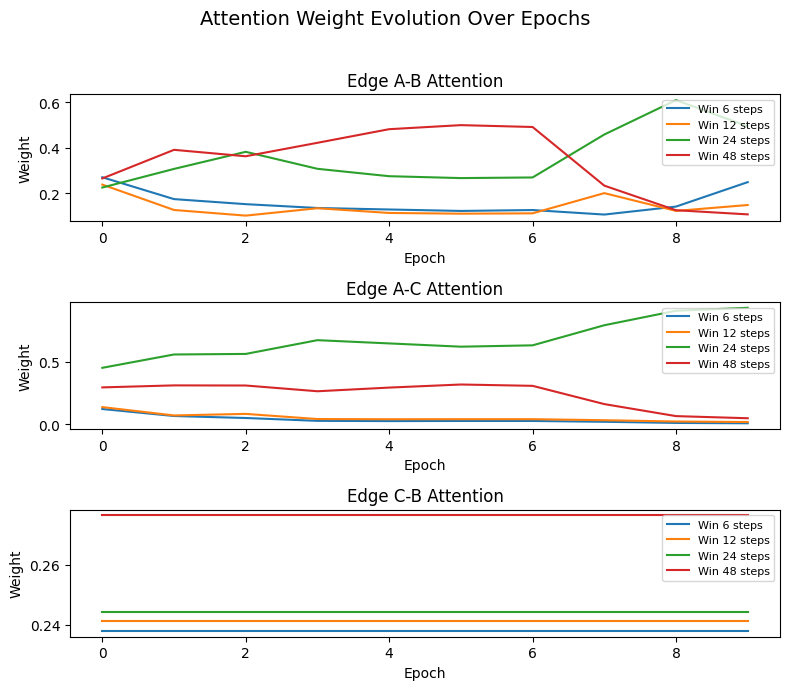


Final Attention Weights (Softmaxed):
  Edge A-B ([6, 12, 24, 48]): [0.249 0.148 0.495 0.107]
  Edge A-C ([6, 12, 24, 48]): [0.007 0.017 0.929 0.047]
  Edge C-B ([6, 12, 24, 48]): [0.238 0.241 0.244 0.276]


In [6]:
# Dataset and DataLoader setup
WINDOW_SIZE = 12

dataset = MarketDatasetMultiWindow(df, corr_array, window=WINDOW_SIZE)
# Using batch_size=1 due to the custom collate_fn and complexity of dynamic sequence inputs
loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn_multiwindow)

# Model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiWindowGNN(n_windows=len(candidate_windows)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 10
attn_history = []  # to monitor attention weights per epoch

print(f"Training on {len(dataset)} samples using {device}.")

for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0
    for x_seq, idx, target, corr_slice in loader:
        optimizer.zero_grad()
        
        # output is (1, n_classes), target is (1)
        output, attn_weights = model(x_seq, corr_slice)
        loss = criterion(output.unsqueeze(0), target.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Save attention weights after each epoch
    attn_history.append(attn_weights.detach().cpu().numpy().copy())
    print(f"Epoch {epoch+1}/{n_epochs}, Avg Loss: {total_loss/len(loader):.4f}")
    

# Convert attention history to array (n_epochs, n_edges, n_windows)
attn_history = np.stack(attn_history, axis=0)
print('\nAttention history shape:', attn_history.shape)

# Plot attention evolution
fig, axes = plt.subplots(n_edges, 1, figsize=(8, 7))
plt.suptitle('Attention Weight Evolution Over Epochs', fontsize=14)

for e in range(n_edges):
    for w in range(model.n_windows):
        axes[e].plot(attn_history[:,e,w], label=f'Win {candidate_windows[w]} steps')
        
    axes[e].set_title(f'Edge {edges[e][0]}-{edges[e][1]} Attention')
    axes[e].set_ylabel('Weight')
    axes[e].set_xlabel('Epoch')
    axes[e].legend(loc='upper right', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
plt.show()

print('\nFinal Attention Weights (Softmaxed):')
for e, edge in enumerate(edges):
    weights = attn_history[-1, e, :]
    print(f'  Edge {edge[0]}-{edge[1]} ({candidate_windows}): {np.round(weights, 3)}')
